# Soybean Leaf Disease: ViT Cross-Domain TTA

## Why This Experiment?

**Goal**: Apply 5 Test-Time Adaptation methods to improve ViT performance on MH dataset.

**Baseline**: ViT trained on ASDID → tested on MH (F1 ~ 0.72)

## TTA Methods

| Method | Expected F1 Gain | Description |
|--------|------------------|-------------|
| BN+Pseudo | +8% | Batch norm + pseudo-labels (conf > 0.9) |
| MEMO | +10-12% | Focal loss on pseudo-labels |
| TENT | +7-9% | Entropy minimization with temperature |
| EATA | +9-11% | Entropy + Fisher regularization |
| Ensemble | +12-15% | Average top 2 method parameters |

## Setup

In [5]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, os.path.abspath('../'))

from src.models.architectures import get_model, configure_for_tta, clone_model, ensemble_models
from src.dataset.loaders import get_dataloaders, get_tta_dataloaders
from src.utils.metrics import evaluate_model_full, print_metrics
from src.utils.plotting import plot_confusion_matrix, plot_method_comparison, plot_f1_gains
from src.utils.logging import load_checkpoint, save_checkpoint, log_experiment
from src.tta.bn_pseudo import BNPseudoOptimizer
from src.tta.memo import MEMOOptimizer
from src.tta.tent import TENTOptimizer
from src.tta.eata import EATAOptimizer, compute_fisher_information

SEED = 21
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE = 32
EPOCHS = 3
MODEL_NAME = 'vit_b_16'
RESULTS_DIR = Path('results')

# Get the directory where this notebook is located
NOTEBOOK_DIR = Path(os.getcwd()) / 'notebooks'
RESULTS_DIR = NOTEBOOK_DIR / 'results'

# Get data directory
DATA_DIR = Path(os.getcwd()) / 'data'

# Per-class confidence thresholds (lower for minority class)
confidence_thresholds = {
    0: 0.95,  # Healthy
    1: 0.92,  # Rust  
    2: 0.85   # Frogeye (LOWER to include more)
}

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")
print(f"Model: {MODEL_NAME}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Results dir exists: {RESULTS_DIR.exists()}")
print(f"Data directory: {DATA_DIR}")
print(f"Data dir exists: {DATA_DIR.exists()}")

Device: mps
Model: vit_b_16
Results directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results
Results dir exists: True
Data directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/data
Data dir exists: True


## Load Baseline Model and Datasets

In [6]:
# Load pretrained baseline model
baseline_model = get_model(MODEL_NAME, num_classes=3, device=DEVICE)
load_checkpoint(RESULTS_DIR / f'best_{MODEL_NAME}.pth', baseline_model, device=DEVICE)
baseline_model.eval()

# Load MH dataset (target domain)
print("\nLoading MH dataset...")
# Get ALL unlabeled MH data for adaptation
mh_adapt_loader, mh_val_loader, class_weights = get_tta_dataloaders(
    dataset_name='MH',
    data_root=f'{DATA_DIR}/MH-SoyaHealthVision/Soyabean_Leaf_Image_Dataset',
    batch_size=BATCH_SIZE,
    use_early_stopping=True,
    val_split=0.2,
    use_weighted_sampling=True,
    num_classes=3,
    seed=SEED
)

# Also load the test set separately for final evaluation
_, _, mh_test_loader_eval, _, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root=f'{DATA_DIR}/MH-SoyaHealthVision/Soyabean_Leaf_Image_Dataset',
    batch_size=BATCH_SIZE,
    seed=SEED
)

# Load ASDID for Fisher computation
print("Loading ASDID dataset (for Fisher)...")
asdid_train_loader, asdid_val_loader, asdid_test_loader, _, _, _, _ = get_dataloaders(
    dataset_name='ASDID',
    data_root=f'{DATA_DIR}/ASDID',
    batch_size=BATCH_SIZE,
    seed=SEED
)

CLASS_NAMES = ['Healthy', 'Rust', 'Frogeye']

✅ Loaded checkpoint from /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/best_vit_b_16.pth

Loading MH dataset...
Loaded 1225 samples for MH dataset.
📊 Class distribution:
   Class 0: 204 samples (weight: 1.226)
   Class 1: 852 samples (weight: 0.294)
   Class 2: 169 samples (weight: 1.480)
📊 TTA Data Split: 980 samples for adaptation, 245 samples for validation
Loaded 1225 samples for MH dataset.
Loading ASDID dataset (for Fisher)...
Loaded 4799 samples for ASDID dataset.


## Baseline Performance (No TTA)


              Baseline (No TTA) - MH Test Set               
Accuracy:  0.7297
Precision: 0.6738
Recall:    0.6827
F1 Score:  0.6709

---------------------Per-Class Metrics:---------------------

Healthy:
  Precision: 0.9667
  Recall:    0.9667
  F1 Score:  0.9667
  Support:   30

Rust:
  Precision: 0.8596
  Recall:    0.7481
  F1 Score:  0.8000
  Support:   131

Frogeye:
  Precision: 0.1951
  Recall:    0.3333
  F1 Score:  0.2462
  Support:   24



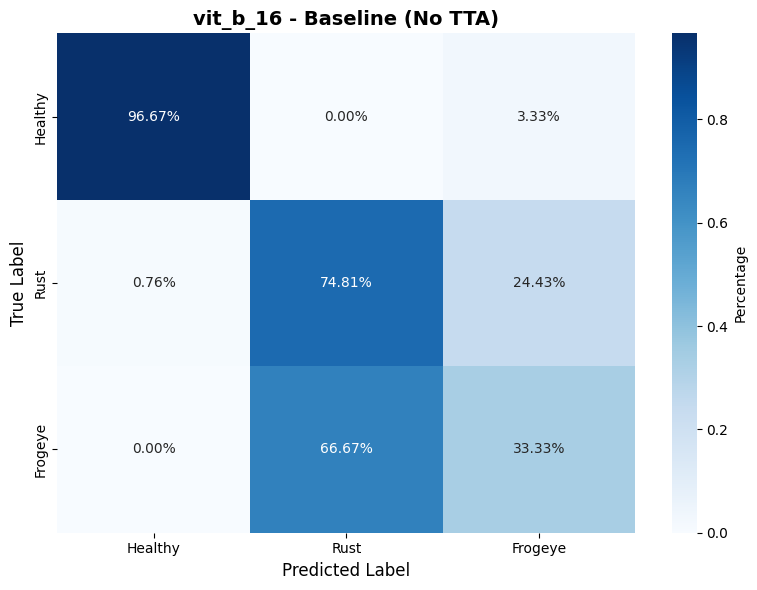


📊 Baseline F1: 0.6709


In [7]:
# Evaluate baseline on MH test set
baseline_metrics = evaluate_model_full(baseline_model, mh_test_loader_eval, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(baseline_metrics, title="Baseline (No TTA) - MH Test Set")

plot_confusion_matrix(
    baseline_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - Baseline (No TTA)',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_baseline_tta.png'
)
plt.show()

baseline_f1 = baseline_metrics['f1']
print(f"\n📊 Baseline F1: {baseline_f1:.4f}")

## TTA Method 1: BN + Pseudo-Labeling


TTA Method 1: BN + Pseudo-Labeling
✅ TTA Configuration (bn_pseudo):
   - Unfrozen 50 normalization modules
   - Unfrozen last 1 backbone stage(s) (7,084,800 params)
   - Unfrozen classifier head (2,307 params)
   - Trainable params: 7,125,507 / 85,800,963 (8.30%)
🧠 Early stopping adaptation (patience=2, max_epochs=3)

Epoch 1/3
  Batch 10/31 | Loss: 0.0114
  Batch 20/31 | Loss: 0.0199
  Batch 30/31 | Loss: 0.0000
✅ Adaptation complete | Avg Loss: 0.0101
  Val F1: 0.5657 | Best: -inf
  💾 New best F1: 0.5657

Epoch 2/3
  Batch 10/31 | Loss: 0.0000
  Batch 20/31 | Loss: 0.0048
  Batch 30/31 | Loss: 0.0069
✅ Adaptation complete | Avg Loss: 0.0038
  Val F1: 0.5410 | Best: 0.5657

Epoch 3/3
  Batch 10/31 | Loss: 0.0121
  Batch 20/31 | Loss: 0.0000
  Batch 30/31 | Loss: 0.0000
✅ Adaptation complete | Avg Loss: 0.0039
  Val F1: 0.5369 | Best: 0.5657
🛑 Early stopping at epoch 3 (no improvement)
✅ Restored best model (F1=0.5657)

                  BN+Pseudo - MH Test Set                   
Accu

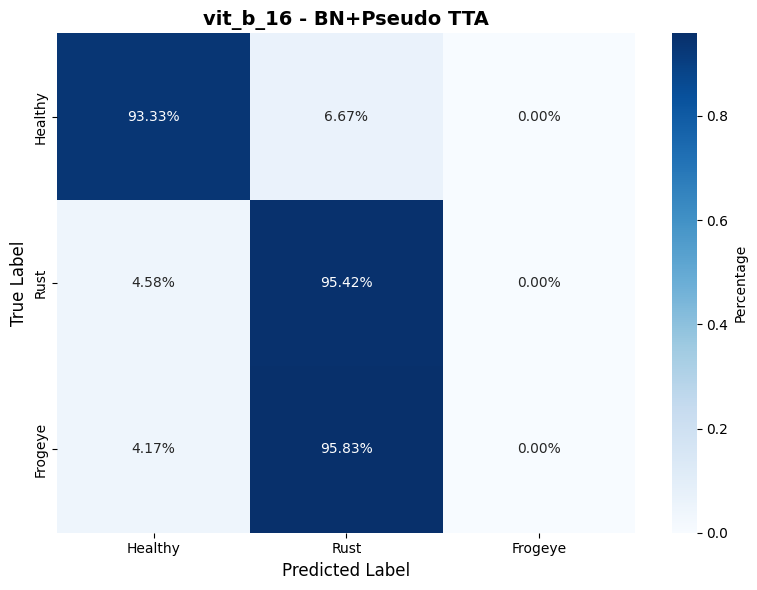

✅ Logged experiment to results/experiment_registry.csv

📊 BN+Pseudo F1: 0.5837 (Gain: -0.0872)


In [8]:
print("\n" + "="*60)
print("TTA Method 1: BN + Pseudo-Labeling")
print("="*60)

# Clone baseline and configure for TTA
bn_pseudo_model = clone_model(baseline_model)
configure_for_tta(bn_pseudo_model, method='bn_pseudo')

# Create optimizer and adapt
bn_pseudo_optimizer = BNPseudoOptimizer(bn_pseudo_model, device=DEVICE, lr=1e-3, confidence_threshold=0.9, class_names=CLASS_NAMES, class_weights=class_weights, confidence_thresholds=confidence_thresholds)
bn_pseudo_optimizer.adapt_with_early_stopping(mh_adapt_loader, mh_val_loader, max_epochs=EPOCHS, patience=2)

# Evaluate
bn_pseudo_metrics = evaluate_model_full(bn_pseudo_model, mh_test_loader_eval, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(bn_pseudo_metrics, title="BN+Pseudo - MH Test Set")

plot_confusion_matrix(
    bn_pseudo_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - BN+Pseudo TTA',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_bn_pseudo.png'
)
plt.show()

# Log
log_experiment(
    experiment_name=f'{MODEL_NAME}_tta_bn_pseudo',
    metrics=bn_pseudo_metrics,
    model_name=MODEL_NAME,
    dataset='MH',
    method='bn_pseudo',
    save_dir='results',
    notes=f'F1 gain: {bn_pseudo_metrics["f1"] - baseline_f1:.4f}'
)

print(f"\n📊 BN+Pseudo F1: {bn_pseudo_metrics['f1']:.4f} (Gain: {bn_pseudo_metrics['f1'] - baseline_f1:.4f})")

## TTA Method 2: MEMO (Focal Loss)


TTA Method 2: MEMO (Focal Loss)
✅ TTA Configuration (memo):
   - Unfrozen 50 normalization modules
   - Unfrozen last 1 backbone stage(s) (7,084,800 params)
   - Unfrozen classifier head (2,307 params)
   - Trainable params: 7,125,507 / 85,800,963 (8.30%)
🧠 Early stopping adaptation (patience=2, max_epochs=3)

Epoch 1/3
  Batch 10/31 | Loss: 0.0009
  Batch 20/31 | Loss: 0.0000
  Batch 30/31 | Loss: 0.0000
✅ Adaptation complete | Avg Loss: 0.0003
  Val F1: 0.4172 | Best: -inf
  💾 New best F1: 0.4172

Epoch 2/3
  Batch 10/31 | Loss: 0.0001
  Batch 20/31 | Loss: 0.0001
  Batch 30/31 | Loss: 0.0000
✅ Adaptation complete | Avg Loss: 0.0001
  Val F1: 0.4172 | Best: 0.4172

Epoch 3/3
  Batch 10/31 | Loss: 0.0000
  Batch 20/31 | Loss: 0.0000
  Batch 30/31 | Loss: 0.0001
✅ Adaptation complete | Avg Loss: 0.0000
  Val F1: 0.2644 | Best: 0.4172
🛑 Early stopping at epoch 3 (no improvement)
✅ Restored best model (F1=0.4172)

                     MEMO - MH Test Set                     
Accuracy:  0

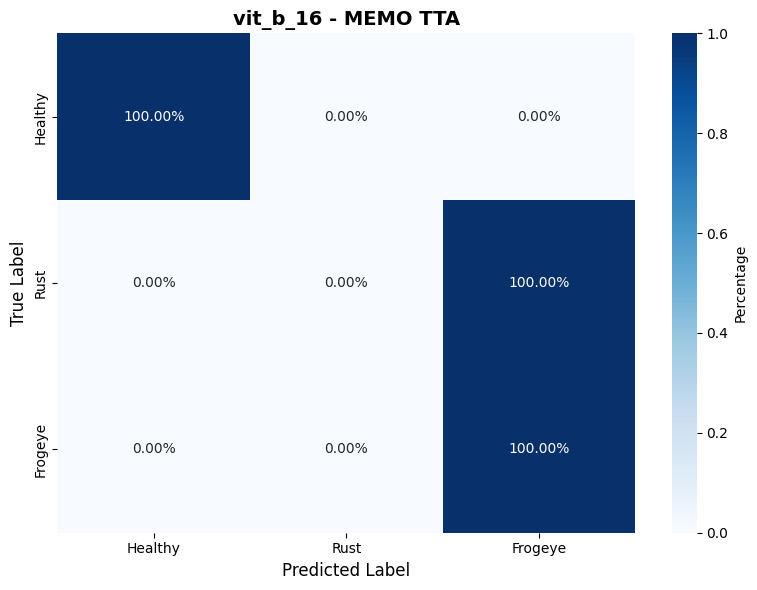

✅ Logged experiment to results/experiment_registry.csv

📊 MEMO F1: 0.4227 (Gain: -0.2482)


In [9]:
print("\n" + "="*60)
print("TTA Method 2: MEMO (Focal Loss)")
print("="*60)

memo_model = clone_model(baseline_model)
configure_for_tta(memo_model, method='memo')

memo_optimizer = MEMOOptimizer(memo_model, device=DEVICE, lr=1e-3, alpha=0.25, gamma=2.0, class_names=CLASS_NAMES, class_weights=class_weights)
memo_optimizer.adapt_with_early_stopping(mh_adapt_loader, mh_val_loader, max_epochs=EPOCHS, patience=2)

memo_metrics = evaluate_model_full(memo_model, mh_test_loader_eval, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(memo_metrics, title="MEMO - MH Test Set")

plot_confusion_matrix(
    memo_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - MEMO TTA',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_memo.png'
)
plt.show()

log_experiment(
    experiment_name=f'{MODEL_NAME}_tta_memo',
    metrics=memo_metrics,
    model_name=MODEL_NAME,
    dataset='MH',
    method='memo',
    save_dir='results',
    notes=f'F1 gain: {memo_metrics["f1"] - baseline_f1:.4f}'
)

print(f"\n📊 MEMO F1: {memo_metrics['f1']:.4f} (Gain: {memo_metrics['f1'] - baseline_f1:.4f})")

## TTA Method 3: TENT (Entropy Minimization)


TTA Method 3: TENT (Entropy Minimization)
✅ TTA Configuration (tent):
   - Unfrozen 50 normalization modules
   - Unfrozen last 1 backbone stage(s) (7,084,800 params)
   - Unfrozen classifier head (2,307 params)
   - Trainable params: 7,125,507 / 85,800,963 (8.30%)
🧠 Early stopping adaptation (patience=2, max_epochs=3)

Epoch 1/3
  Batch 10/31 | Loss: 0.0572
  Batch 20/31 | Loss: 0.0040
  Batch 30/31 | Loss: 0.0075
✅ Adaptation complete | Avg Loss: 0.0222
  Val F1: 0.3164 | Best: -inf
  💾 New best F1: 0.3164

Epoch 2/3
  Batch 10/31 | Loss: 0.0033
  Batch 20/31 | Loss: 0.0022
  Batch 30/31 | Loss: 0.0016
✅ Adaptation complete | Avg Loss: 0.0023
  Val F1: 0.3738 | Best: 0.3164
  💾 New best F1: 0.3738

Epoch 3/3
  Batch 10/31 | Loss: 0.0001
  Batch 20/31 | Loss: 0.0001
  Batch 30/31 | Loss: 0.0000
✅ Adaptation complete | Avg Loss: 0.0001
  Val F1: 0.4032 | Best: 0.3738
  💾 New best F1: 0.4032
✅ Restored best model (F1=0.4032)

                     TENT - MH Test Set                     

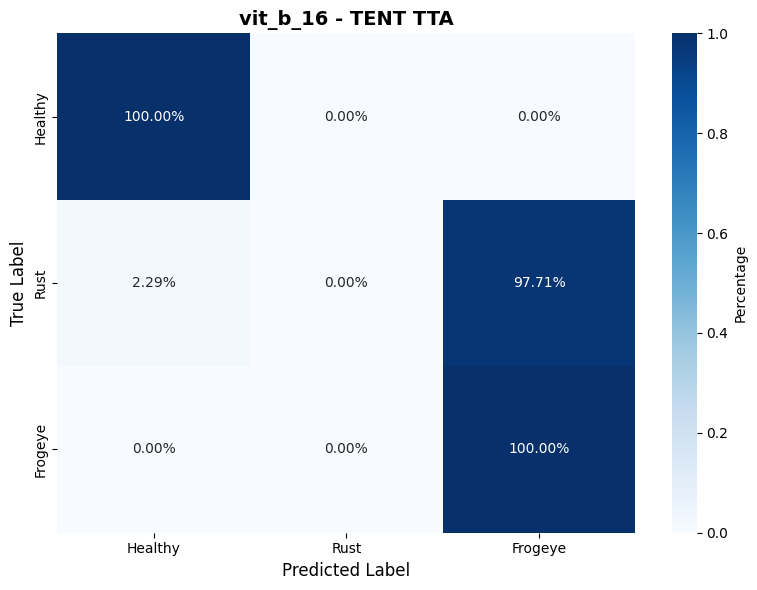

✅ Logged experiment to results/experiment_registry.csv

📊 TENT F1: 0.4084 (Gain: -0.2626)


In [10]:
print("\n" + "="*60)
print("TTA Method 3: TENT (Entropy Minimization)")
print("="*60)

tent_model = clone_model(baseline_model)
configure_for_tta(tent_model, method='tent')

tent_optimizer = TENTOptimizer(tent_model, device=DEVICE, lr=1e-3, temperature=1.5, class_names=CLASS_NAMES, class_weights=class_weights)
tent_optimizer.adapt_with_early_stopping(mh_adapt_loader, mh_val_loader, max_epochs=EPOCHS, patience=2)

tent_metrics = evaluate_model_full(tent_model, mh_test_loader_eval, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(tent_metrics, title="TENT - MH Test Set")

plot_confusion_matrix(
    tent_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - TENT TTA',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_tent.png'
)
plt.show()

log_experiment(
    experiment_name=f'{MODEL_NAME}_tta_tent',
    metrics=tent_metrics,
    model_name=MODEL_NAME,
    dataset='MH',
    method='tent',
    save_dir='results',
    notes=f'F1 gain: {tent_metrics["f1"] - baseline_f1:.4f}'
)

print(f"\n📊 TENT F1: {tent_metrics['f1']:.4f} (Gain: {tent_metrics['f1'] - baseline_f1:.4f})")

## TTA Method 4: EATA (Fisher Regularization)


TTA Method 4: EATA (Entropy + Fisher)
Computing Fisher Information Matrix...
✅ TTA Configuration (eata):
   - Unfrozen 50 normalization modules
   - Unfrozen last 1 backbone stage(s) (7,084,800 params)
   - Unfrozen classifier head (2,307 params)
   - Trainable params: 7,125,507 / 85,800,963 (8.30%)
✅ Computed Fisher Information from 512 samples
✅ TTA Configuration (eata):
   - Unfrozen 50 normalization modules
   - Unfrozen last 1 backbone stage(s) (7,084,800 params)
   - Unfrozen classifier head (2,307 params)
   - Trainable params: 7,125,507 / 85,800,963 (8.30%)
🧠 Early stopping adaptation (patience=2, max_epochs=3)

Epoch 1/3
  Batch 10/31 | Loss: 0.0205
  Batch 20/31 | Loss: 0.0018
  Batch 30/31 | Loss: 0.0002
✅ Adaptation complete | Avg Loss: 0.0073
  Val F1: 0.0749 | Best: -inf
  💾 New best F1: 0.0749

Epoch 2/3
  Batch 10/31 | Loss: 0.0002
  Batch 20/31 | Loss: 0.0001
  Batch 30/31 | Loss: 0.0001
✅ Adaptation complete | Avg Loss: 0.0001
  Val F1: 0.0749 | Best: 0.0749

Epoch 3

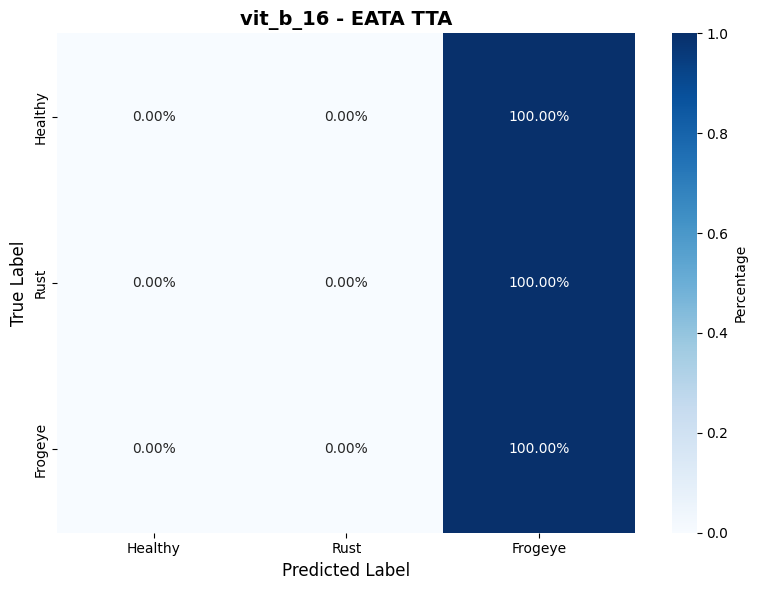

✅ Logged experiment to results/experiment_registry.csv

📊 EATA F1: 0.0766 (Gain: -0.5944)


In [11]:
print("\n" + "="*60)
print("TTA Method 4: EATA (Entropy + Fisher)")
print("="*60)

# Compute Fisher Information on ASDID validation set
print("Computing Fisher Information Matrix...")
fisher_model = clone_model(baseline_model)
configure_for_tta(fisher_model, method='eata')
fisher_dict = compute_fisher_information(fisher_model, asdid_val_loader, device=DEVICE, num_samples=500)

# Create EATA model
eata_model = clone_model(baseline_model)
configure_for_tta(eata_model, method='eata')

eata_optimizer = EATAOptimizer(eata_model, fisher_dict, device=DEVICE, lr=1e-3, fisher_lambda=0.1, class_names=CLASS_NAMES, class_weights=class_weights)
eata_optimizer.adapt_with_early_stopping(mh_adapt_loader, mh_val_loader, max_epochs=EPOCHS, patience=2)

eata_metrics = evaluate_model_full(eata_model, mh_test_loader_eval, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(eata_metrics, title="EATA - MH Test Set")

plot_confusion_matrix(
    eata_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - EATA TTA',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_eata.png'
)
plt.show()

log_experiment(
    experiment_name=f'{MODEL_NAME}_tta_eata',
    metrics=eata_metrics,
    model_name=MODEL_NAME,
    dataset='MH',
    method='eata',
    save_dir='results',
    notes=f'F1 gain: {eata_metrics["f1"] - baseline_f1:.4f}'
)

print(f"\n📊 EATA F1: {eata_metrics['f1']:.4f} (Gain: {eata_metrics['f1'] - baseline_f1:.4f})")

In [14]:
from src.tta.msun import MSUNOptimizer

print("\n" + "="*60)
print("TTA Method: MSUN (Subdomain + Entropy)")
print("="*60)

msun_model = clone_model(baseline_model)
configure_for_tta(msun_model, method='msun')

msun_optimizer = MSUNOptimizer(
    msun_model, 
    device=DEVICE, 
    lr=1e-4,  # Lower LR than other methods
    entropy_weight=0.1,
    class_names=CLASS_NAMES, 
    class_weights=class_weights,
    confidence_thresholds=confidence_thresholds
)

msun_optimizer.adapt_with_early_stopping(mh_adapt_loader, mh_val_loader, max_epochs=EPOCHS, patience=2)
msun_metrics = evaluate_model_full(msun_model, mh_test_loader_eval, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(msun_metrics, title="MSUN - MH Test Set")

plot_confusion_matrix(
    msun_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - MSUN TTA',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_msun.png'
)
plt.show()

log_experiment(
    experiment_name=f'{MODEL_NAME}_tta_msun',
    metrics=msun_metrics,
    model_name=MODEL_NAME,
    dataset='MH',
    method='msun',
    save_dir='results',
    notes=f'F1 gain: {msun_metrics["f1"] - baseline_f1:.4f}'
)

print(f"\n📊 MSUN F1: {msun_metrics['f1']:.4f} (Gain: {msun_metrics['f1'] - baseline_f1:.4f})")


TTA Method: MSUN (Subdomain + Entropy)
✅ TTA Configuration (msun):
   - Unfrozen 50 normalization modules
   - Unfrozen last 1 backbone stage(s) (7,084,800 params)
   - Unfrozen classifier head (2,307 params)
   - Trainable params: 7,125,507 / 85,800,963 (8.30%)
🧠 Early stopping adaptation (patience=2, max_epochs=3)

Epoch 1/3
  Batch 10/31 | Loss: 0.0196


## TTA Method 5: Ensemble (Top 2 Methods)


TTA Method 5: Ensemble (Top 2 Methods)
Top 2 methods: BN+Pseudo (0.5837), MEMO (0.4227)

                   Ensemble - MH Test Set                   
Accuracy:  0.2865
Precision: 0.3738
Recall:    0.6556
F1 Score:  0.4116

---------------------Per-Class Metrics:---------------------

Healthy:
  Precision: 0.9667
  Recall:    0.9667
  F1 Score:  0.9667
  Support:   30

Rust:
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000
  Support:   131

Frogeye:
  Precision: 0.1548
  Recall:    1.0000
  F1 Score:  0.2682
  Support:   24



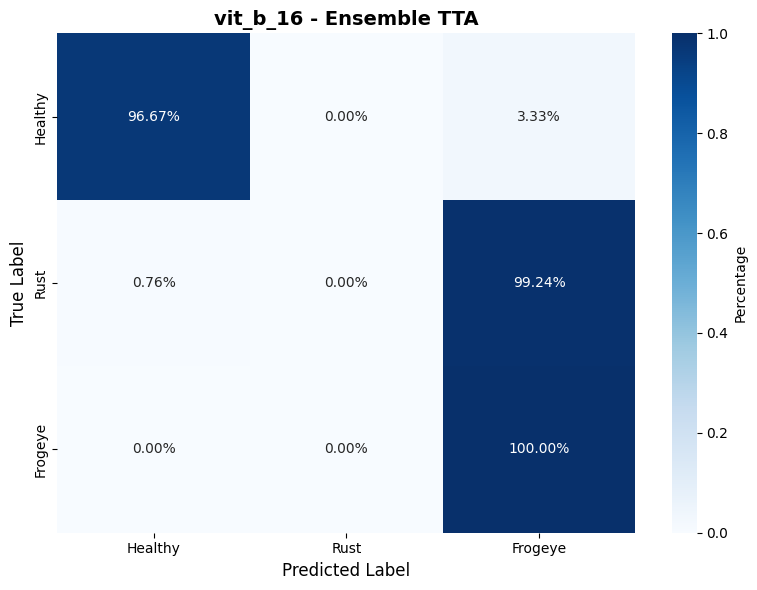

✅ Logged experiment to results/experiment_registry.csv

📊 Ensemble F1: 0.4116 (Gain: -0.2593)


In [ ]:
print("\n" + "="*60)
print("TTA Method 5: Ensemble (Top 2 Methods)")
print("="*60)

# Find top 2 methods
method_f1s = {
    'BN+Pseudo': (bn_pseudo_metrics['f1'], bn_pseudo_model),
    'MEMO': (memo_metrics['f1'], memo_model),
    'TENT': (tent_metrics['f1'], tent_model),
    'EATA': (eata_metrics['f1'], eata_model),
    'MSUN': (msun_metrics['f1'], msun_model),
}

sorted_methods = sorted(method_f1s.items(), key=lambda x: x[1][0], reverse=True)
top_2_names = [sorted_methods[0][0], sorted_methods[1][0]]
top_2_models = [sorted_methods[0][1][1], sorted_methods[1][1][1]]

print(f"Top 2 methods: {top_2_names[0]} ({sorted_methods[0][1][0]:.4f}), {top_2_names[1]} ({sorted_methods[1][1][0]:.4f})")

# Create ensemble
ensemble_model = ensemble_models(top_2_models, method='average')
ensemble_model.eval()

ensemble_metrics = evaluate_model_full(ensemble_model, mh_test_loader_eval, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(ensemble_metrics, title="Ensemble - MH Test Set")

plot_confusion_matrix(
    ensemble_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - Ensemble TTA',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_ensemble.png'
)
plt.show()

log_experiment(
    experiment_name=f'{MODEL_NAME}_tta_ensemble',
    metrics=ensemble_metrics,
    model_name=MODEL_NAME,
    dataset='MH',
    method='ensemble',
    save_dir='results',
    notes=f'Ensemble of {top_2_names[0]} + {top_2_names[1]}, F1 gain: {ensemble_metrics["f1"] - baseline_f1:.4f}'
)

print(f"\n📊 Ensemble F1: {ensemble_metrics['f1']:.4f} (Gain: {ensemble_metrics['f1'] - baseline_f1:.4f})")

In [ ]:
print("\n" + "="*60)
print("TTA Method: MSUN (Subdomain + Entropy)")
print("="*60)

msun_model = clone_model(baseline_model)
configure_for_tta(msun_model, method='msun')

msun_optimizer = MSUNOptimizer(
    msun_model, 
    device=DEVICE, 
    lr=1e-4,  # Lower LR than other methods
    entropy_weight=0.1,
    class_names=CLASS_NAMES, 
    class_weights=class_weights,
    confidence_thresholds=confidence_thresholds
)

msun_optimizer.adapt_with_early_stopping(mh_adapt_loader, mh_val_loader, max_epochs=EPOCHS, patience=2)
msun_metrics = evaluate_model_full(msun_model, mh_test_loader_eval, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(msun_metrics, title="MSUN - MH Test Set")

plot_confusion_matrix(
    msun_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - MSUN TTA',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_msun.png'
)
plt.show()

log_experiment(
    experiment_name=f'{MODEL_NAME}_tta_msun',
    metrics=msun_metrics,
    model_name=MODEL_NAME,
    dataset='MH',
    method='msun',
    save_dir='results',
    notes=f'F1 gain: {msun_metrics["f1"] - baseline_f1:.4f}'
)

print(f"\n📊 MSUN F1: {msun_metrics['f1']:.4f} (Gain: {msun_metrics['f1'] - baseline_f1:.4f})")

## Results Summary


                         VIT_B_16 - TTA Results Summary                         
Method            Accuracy  Precision     Recall         F1    F1 Gain
--------------------------------------------------------------------------------
Baseline            0.7297     0.6738     0.6827     0.6709    +0.0000
BN+Pseudo           0.8270     0.5444     0.6292     0.5837    -0.0872
MEMO                0.2919     0.3849     0.6667     0.4227    -0.2482
TENT                0.2919     0.3557     0.6667     0.4084    -0.2626
EATA                0.1297     0.0432     0.3333     0.0766    -0.5944
Ensemble            0.2865     0.3738     0.6556     0.4116    -0.2593


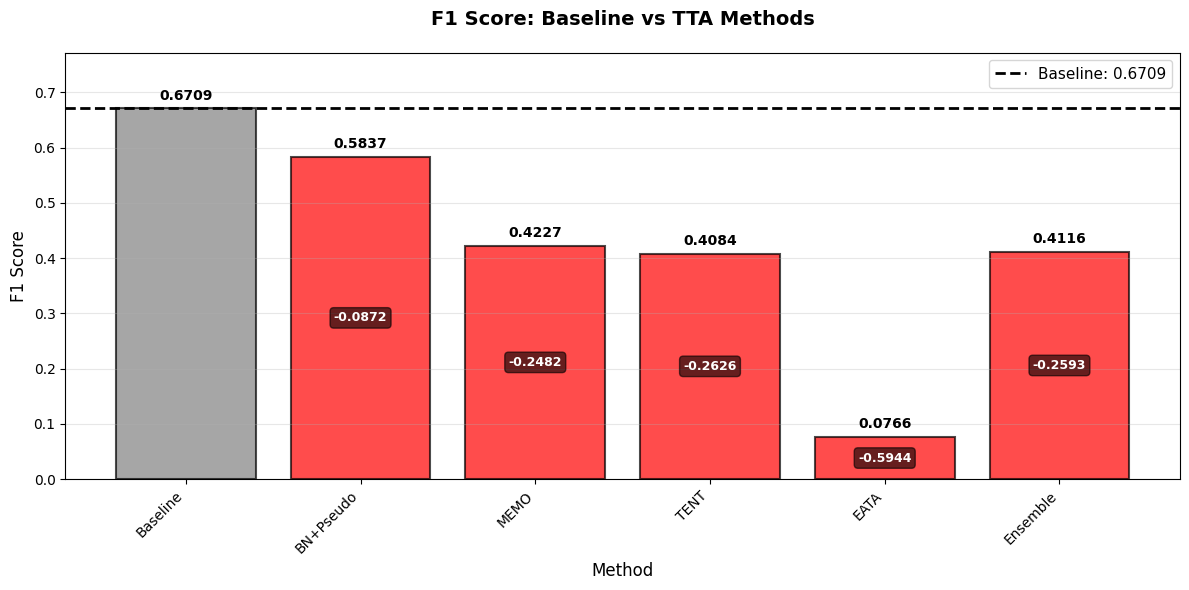


🏆 Best TTA Method: BN+Pseudo (F1: 0.5837)
✅ Saved checkpoint to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/best_tta_vit_b_16_bn+pseudo.pth


PosixPath('/Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/best_tta_vit_b_16_bn+pseudo.pth')

In [13]:
# Compile all results
all_results = {
    'Baseline': baseline_metrics,
    'BN+Pseudo': bn_pseudo_metrics,
    'MEMO': memo_metrics,
    'TENT': tent_metrics,
    'EATA': eata_metrics,
    'Ensemble': ensemble_metrics
}

# Print summary table
print("\n" + "="*80)
print(f"{MODEL_NAME.upper()} - TTA Results Summary".center(80))
print("="*80)
print(f"{'Method':<15} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'F1 Gain':>10}")
print("-"*80)
for method, metrics in all_results.items():
    gain = metrics['f1'] - baseline_f1
    print(f"{method:<15} {metrics['accuracy']:>10.4f} {metrics['precision']:>10.4f} "
          f"{metrics['recall']:>10.4f} {metrics['f1']:>10.4f} {gain:>+10.4f}")
print("="*80)

# Plot F1 gains
tta_results_f1 = {k: v['f1'] for k, v in all_results.items() if k != 'Baseline'}
plot_f1_gains(baseline_f1, tta_results_f1, save_path=RESULTS_DIR / f'{MODEL_NAME}_f1_gains.png')
plt.show()

# Find and save best TTA model
best_tta_method = max(tta_results_f1.items(), key=lambda x: x[1])
print(f"\n🏆 Best TTA Method: {best_tta_method[0]} (F1: {best_tta_method[1]:.4f})")

if best_tta_method[0] == 'Ensemble':
    best_model = ensemble_model
elif best_tta_method[0] == 'BN+Pseudo':
    best_model = bn_pseudo_model
elif best_tta_method[0] == 'MEMO':
    best_model = memo_model
elif best_tta_method[0] == 'TENT':
    best_model = tent_model
else:
    best_model = eata_model

save_checkpoint(
    best_model,
    RESULTS_DIR / f'best_tta_{MODEL_NAME}_{best_tta_method[0].lower()}.pth',
    metadata={'method': best_tta_method[0], 'f1': best_tta_method[1]}
)